<a href="https://colab.research.google.com/github/BenYavor/Autoencoder_communication_system_WGAN_GP_Channel-estimation-in-process-/blob/master/Communication_Autoencoder_with_WGAN_PL_and_pre_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.0.0
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt   
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import tensorflow as tf
import os
tf.__version__
from tensorflow import keras
import time
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import sys
assert sys.version_info >= (3, 5)
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from scipy import special
#from Clustering_Equalgrps.equal_groups import EqualGroupsKMeans
from tensorflow.keras import layers
np.random.seed(42)
tf.random.set_seed(42)

  Using cached https://files.pythonhosted.org/packages/46/0f/7bd55361168bb32796b360ad15a25de6966c9c1beb58a8e30c01c8279862/tensorflow-2.0.0-cp36-cp36m-manylinux2010_x86_64.whl


#### Vergleich
Als erstes für feste $k$ und $n$, was sich ändert ist die Samplesize, Anzahl der Samples und SNR

###Systemparameter
ACHTUNG: CHANNELANZAHL WURDE UNTERSCHIEDLICH VERWENDET \\
$k$ - die Anzhal der bits \\
$M$ - Anzahl der unterschiedlichen Nachrichten \\
$n$ - channel uses\\
$N$ - Länge des Rauschvektors

In [2]:
k = 4      # Number of information bits per message, i.e., M=2**k
M = 2**k
n = 2    # Number of real channel uses per message
#k = int(np.log2(M))
#n = 2
print(M)

SNR = 7


16


## Training Parameter

### Different Layers

In [0]:
randN_initial = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

EncIn = tf.keras.layers.Input(shape=(M,))#, dtype= tf.int32)
e1 = tf.keras.layers.Dense(2*n, activation=None)
e2 = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,int(n/2),2]))
EncOut = tf.keras.layers.Lambda(lambda x: x/tf.sqrt(2*tf.reduce_mean(tf.square(x))))
GenIn = tf.keras.layers.Lambda(lambda x:tf.reshape(x,(tf.shape(x)[0],-1)))
# = tf.keras.layers.Lambda(generator)
DecIn = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,int(n/2),2]))
d1 = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,n]))
d2 = tf.keras.layers.Dense(M, activation='relu')
DecOut = tf.keras.layers.Dense(M, activation='softmax')


#noise_std = EbNo_to_noise(TRAINING_SNR)
# custom functions / layers without weights
norm_layer = keras.layers.Lambda(lambda x: tf.divide(x,tf.sqrt(2*tf.reduce_mean(tf.square(x)))))
shape_layer = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2,n]))
shape_layer2 = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,n]))
channel_layer = keras.layers.Lambda(lambda x: x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std))

### Help functions

In [4]:
def EbNo2Sigma(ebnodb):
    '''Convert Eb/No in dB to noise standard deviation'''
    ebno = 10**(ebnodb/10)
    return 1/np.sqrt(2*(2*k/n)*ebno)

def EbNo_to_noise(ebnodb):
    '''Transform EbNo[dB]/snr to noise power'''
    ebno = 10**(ebnodb/10)
    noise_std = 1/np.sqrt(2*(2*k/n)*ebno) 
    return noise_std


def real_channel(x,noise_std):
    # Black-box Channel
    #AWGN
    return x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)

def rayleigh_channel(x,noise_std):
    return x + tf.sqrt(tf.square(tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)) + tf.square(tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)))
    #Uniform U(-3;3)    
    #return x + tf.random_uniform(tf.shape(x), minval=-2, maxval=2)

def B_Ber(input_msg, msg):
    '''Calculate the Batch Bit Error Rate'''
    pred_error = tf.not_equal(tf.argmax(msg, 1), tf.argmax(input_msg, 1))
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

def random_sample(batch_size=32):
    msg = np.random.randint(M, size=batch_size)
    return msg




def B_Ber_m(input_msg, msg):
    '''Calculate the Batch Bit Error Rate'''
    pred_error = tf.not_equal(input_msg, tf.argmax(msg, 1))      
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

def SNR_to_noise(snrdb):
    '''Transform EbNo[dB]/snr to noise power'''
    snr = 10**(snrdb/10)
    noise_std = 1/np.sqrt(2*snr)
    return noise_std

noise_std = EbNo2Sigma(SNR)

print(EbNo2Sigma(SNR))
print(EbNo_to_noise(SNR))

0.15792649852735607
0.15792649852735607


In [0]:
def test_encoding(M=16, n=1):
    inp = np.arange(0,M)
    coding = gan_encoder.predict(inp)
    fig = plt.figure(figsize=(4,4))
    plt.plot(coding[:,0], coding[:, 1], "b.")
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()


def test_encoding_pre(M=16, n=1):
    inp = np.arange(0,M)
    coding = pre_encoder.predict(inp)
    fig = plt.figure(figsize=(4,4))
    plt.plot(coding[:,0], coding[:, 1], "b.")
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()    


# Models

#### Generator Model

In [0]:
def get_generator(n):
  input1 = tf.keras.layers.Input(shape=(n,))
  x1 = tf.keras.layers.Dense(n)(input1)
  input2 =tf.random.normal(shape=tf.shape(input1))
  #input2 =tf.random.normal([tf.shape(input1)[0],n])
  x2 = tf.keras.layers.Dense(n)(input2)
  subtracted = tf.keras.layers.Concatenate(1)([x1, x2])
  h1 = tf.keras.layers.Dense(64,use_bias=True,  activation='relu')(subtracted)
  h2 = tf.keras.layers.Dense(64,use_bias=True, activation='relu')(h1)
  out = tf.keras.layers.Dense(n, use_bias= True, activation='linear')(h2)
  generator = tf.keras.models.Model(inputs=[input1], outputs=out)
  return generator

#### Discriminator Model 

In [0]:
def get_discriminator(n):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(32,use_bias=True, kernel_initializer=randN_initial,activation='relu',input_shape=((2*n,))))
  model.add(tf.keras.layers.Dense(32,use_bias=True, kernel_initializer=randN_initial, activation='relu'))
  model.add(tf.keras.layers.Dense(1,use_bias=False, activation='sigmoid'))
  return model


In [0]:
generator = get_generator(n)
discriminator = get_discriminator(n)

## Encoder and Pre-Encoder Model

In [0]:
def get_gan_encoder(M):
  model = keras.models.Sequential([
            keras.layers.Embedding(M, M, embeddings_initializer='glorot_normal'),
            keras.layers.Dense(M*2, activation="elu"),
            keras.layers.Dense(M*2, activation="elu"),
            keras.layers.Dense(n, activation=None),
            e2,
            EncOut,
            GenIn])
  return model

def get_pre_encoder(M):
  model = keras.models.Sequential([
            keras.layers.Embedding(M, M, embeddings_initializer='glorot_normal'),
            keras.layers.Dense(M,kernel_initializer=randN_initial, activation="elu"),
            keras.layers.Dense(n,kernel_initializer=randN_initial, activation=None),
            e2,
            EncOut,
            GenIn])
  return model

## Decoder and Pre-Decoder Model

In [0]:
def get_gan_decoder(M):
   model= keras.models.Sequential([
                #DecIn,
                #d1,
                keras.layers.Input(shape=(n,)),
                keras.layers.Dense(M*2, activation="elu"),
                keras.layers.Dense(M*2, activation="elu"),
                keras.layers.Dense(M, activation="softmax")
                ])
   return model


def get_pre_decoder(M):
   model= keras.models.Sequential([
                #DecIn,
                #d1,
                keras.layers.Input(shape=(n,)),
                keras.layers.Dense(M,kernel_initializer=randN_initial, activation="elu"),
                keras.layers.Dense(M,kernel_initializer=randN_initial, activation="softmax")
                ])
   return model


### GAN Training functions

In [0]:
gen_optimizer = tf.keras.optimizers.RMSprop(0.0001) # works as well
disc_optimizer = tf.keras.optimizers.RMSprop(0.0001)  #(0.001)# train the model

In [0]:
def gan_Test_AE(data):
    '''Calculate Bit Error for varying SNRs'''
    snr_range = np.linspace(0, 15, 31)
    bber_vec = [None] * len(snr_range)
        
    for db in range(len(snr_range)):           
        noise_std = EbNo_to_noise(snr_range[db])
        code_word = gan_encoder(data)
        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std)
        dcoded_msg = gan_decoder(rcvd_word)
        bber_vec[db] = B_Ber_m(data, dcoded_msg)
        if (db % 6 == 0) & (db > 0):
            print(f'Progress: {db} of {30} parts')

    return (snr_range, bber_vec)

def Test_AE_rayleigh(data):
    '''Calculate Bit Error for varying SNRs'''
    snr_range = np.linspace(0, 15, 31)
    bber_vec = [None] * len(snr_range)
        
    for db in range(len(snr_range)):           
        noise_std = EbNo_to_noise(snr_range[db])
        code_word = gan_encoder(data)
        rcvd_word = rayleigh_channel(code_word, noise_std)
        dcoded_msg = gan_decoder(rcvd_word)
        bber_vec[db] = B_Ber_m(data, dcoded_msg)
        if (db % 6 == 0) & (db > 0):
            print(f'Progress: {db} of {30} parts')

    return (snr_range, bber_vec)


In [0]:
@tf.function
def train(batch_size):
  gen_gradients, disc_gradients = compute_gradients(batch_size)
  apply_gradients(gen_gradients, disc_gradients)

In [0]:
@tf.function
def compute_gradients(batch_size):

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    disc_loss, gen_loss = compute_loss(batch_size)
    #tf.print("gen_loss:", gen_loss)
  disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  return gen_gradients, disc_gradients

In [0]:
def compute_loss(batch_size):
  """ passes through the network and computes loss
  """
        ### pass through network
        # generating noise from a uniform distribution
  ####Mein noise ist anders als hier
  gradient_penalty_weight =  0.1   #0.5
  #print(x_samp)
  # run noise through generator
  m =random_sample(batch_size)
  r = pre_encoder(m)
  real_data = tf.concat(values=[real_channel(r,noise_std), r], axis=1)
  fake_data = tf.concat(values=[generator(r),r], axis=1)
  # discriminate x and x_gen
  logits_x = discriminator(real_data)
  logits_x_gen = discriminator(fake_data)

  # gradient penalty
  d_regularizer = gradient_penalty(real_data, fake_data)
        ### losses
  disc_loss = (tf.reduce_mean(logits_x) - tf.reduce_mean(logits_x_gen)+ d_regularizer * gradient_penalty_weight)

        # losses of fake with label "1"
  gen_loss = tf.reduce_mean(logits_x_gen)
  return disc_loss, gen_loss



def apply_gradients(gen_gradients, disc_gradients):

  gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
  disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

def gradient_penalty(x, x_gen):
  epsilon = tf.random.uniform([x.shape[0], 1, 1, 1], 0.0, 1.0)
  #epsilon = tf.random.uniform(shape = x.shape, minval= 0.0, maxval= 1.0)
  x_hat = epsilon * x + (1 - epsilon) * x_gen
  with tf.GradientTape() as t:
      t.watch(x_hat)
      d_hat = discriminator(x_hat)
  gradients = t.gradient(d_hat, x_hat)
  ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
  d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
  #tf.print("gradient_penalty")
  #tf.print(d_regularizer)
  return d_regularizer



In [0]:
def generate_evaluation_data(batch_size=100):
  x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
  x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) #Average power normalization (not required if standard normal distribution is used )
  fake_eval_data = generator([x])
  real_eval_data = real_channel(x,noise_std) #tf.concat(values=[real_channel(x),x], axis=1)
  inputs = x
  return  real_eval_data, fake_eval_data, inputs 



def get_evaluation_data(evaluation_per_epochs=100):
  real_eval_data = []
  fake_eval_data  = []
  inputs = []
  for i in range(evaluation_per_epochs):
    data = generate_evaluation_data()
    real_eval_data.append(data[0])
    fake_eval_data.append(data[1])
    inputs.append(data[2])
  return real_eval_data, fake_eval_data, inputs


def test_eval(real_eval_data,fake_eval_data,inputs):
  hist_range = 1
  
  
  fake_output_hist = np.mean(fake_eval_data,axis=0)  # Changed from 0 to 1
  real_output_hist = np.mean(real_eval_data,axis=0)
  inputs_hist = np.mean(inputs,axis=0)
    
  fake_output_hist1 = np.reshape( fake_output_hist,[-1,])
  real_output_hist1 = np.reshape( real_output_hist,[-1,])
    
  plt.hist(fake_output_hist1,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')
  plt.hist(real_output_hist1,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')    
  plt.title("noise distribution")
  plt.legend(["generator", "target"])
  plt.show()


In [0]:
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

In [0]:
def gen_train(n_epochs,batch_size):
  generator.trainable =True
  start = time.time()
  for epoch in range(n_epochs):
    x= tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)
    x_samp =x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
    train(batch_size)
    # test on holdout
    loss = []
    if epoch%500 == 0:
      real_c = tf.concat(values=[real_channel(x,noise_std), x], axis=1)
      fake_c = generator(x)
      real_eval_data, fake_eval_data, inputs = get_evaluation_data()
      test_eval(real_eval_data, fake_eval_data, inputs)
      tf.print(fake_c[0])
      #tf.print(disc_loss, gen_loss)
    real_data = tf.concat(values=[real_channel(x,noise_std), x], axis=1)  
    loss.append(compute_loss(batch_size))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    if epoch%100 == 0:
      print(
         "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
              epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
         )  )
  tf.saved_model.save(generator,'/tmp/saved_model/')
  plt.plot(losses.disc_loss.values)
  generator.trainable =False

# Pre Autoencoder Training

Train on 10000000 samples
Epoch 1/5
  196500/10000000 [..............................] - ETA: 1:02 - loss: 0.0024 - accuracy: 1.0000Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, None)              562       
_________________________________________________________________
sequential_1 (Sequential)    (None, 16)                320       
Total params: 882
Trainable params: 882
Non-trainable params: 0
_________________________________________________________________


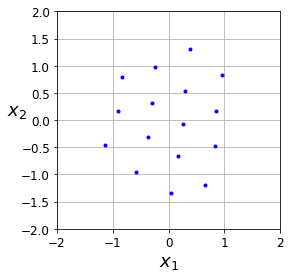

(10000000,)
(10000000, 2)


In [19]:
pre_decoder = get_pre_decoder(M)
pre_encoder = get_pre_encoder(M)



gan_AE = tf.keras.models.Sequential([pre_encoder,pre_decoder])
data, test_data = random_sample(10000000), random_sample(10000)
start = time.time()
gan_AE.compile(optimizer=keras.optimizers.Nadam(lr=0.005),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = gan_AE.fit(data, data, batch_size=500,steps_per_epoch=400, epochs=5)
#pre_encoder.trainable = False
#pre_decoder.trainable = False
gan_AE.summary() 
test_encoding_pre(M,n) 

print(data.shape)
print(pre_encoder(data).shape)

# GAN Training

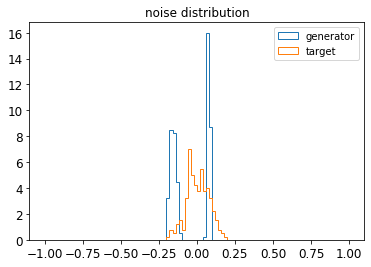

[0.0829345137 -0.0828124732]
Epoch: 0 | disc_loss: 0.09691464155912399 | gen_loss: 0.50152987241745
Epoch: 100 | disc_loss: 0.0828154906630516 | gen_loss: 0.5041761994361877
Epoch: 200 | disc_loss: 0.07061521708965302 | gen_loss: 0.506913959980011
Epoch: 300 | disc_loss: 0.05774356424808502 | gen_loss: 0.5135130286216736
Epoch: 400 | disc_loss: 0.028392978012561798 | gen_loss: 0.5299767255783081


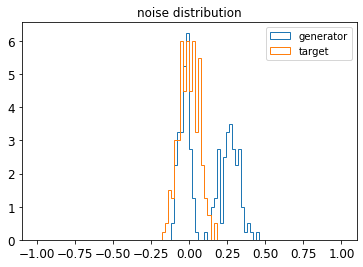

[-0.0225065872 0.720763922]
Epoch: 500 | disc_loss: 0.005766954272985458 | gen_loss: 0.5364473462104797
Epoch: 600 | disc_loss: -0.01598970592021942 | gen_loss: 0.5304464101791382
Epoch: 700 | disc_loss: -0.04120611771941185 | gen_loss: 0.5351019501686096
Epoch: 800 | disc_loss: -0.0652470514178276 | gen_loss: 0.5348585247993469
Epoch: 900 | disc_loss: -0.07580182701349258 | gen_loss: 0.5416688919067383


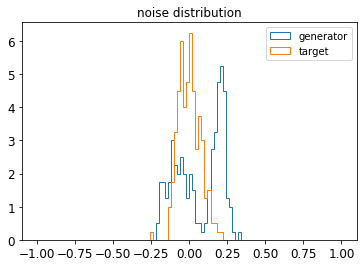

[0.799535275 -0.130077928]
Epoch: 1000 | disc_loss: -0.059606246650218964 | gen_loss: 0.5289230942726135
Epoch: 1100 | disc_loss: -0.025684993714094162 | gen_loss: 0.4929487705230713
Epoch: 1200 | disc_loss: 0.0008552707731723785 | gen_loss: 0.4850272834300995
Epoch: 1300 | disc_loss: 0.027008015662431717 | gen_loss: 0.49036160111427307
Epoch: 1400 | disc_loss: 0.01751525327563286 | gen_loss: 0.47761061787605286


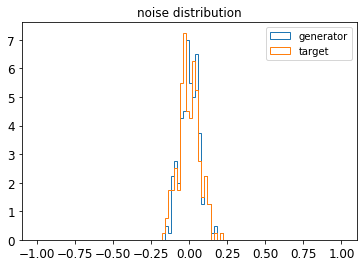

[0.107450128 1.20909488]
Epoch: 1500 | disc_loss: 0.025383491069078445 | gen_loss: 0.46679723262786865
Epoch: 1600 | disc_loss: 0.02775385230779648 | gen_loss: 0.4831571877002716
Epoch: 1700 | disc_loss: 0.02590464986860752 | gen_loss: 0.48984700441360474
Epoch: 1800 | disc_loss: 0.02235272526741028 | gen_loss: 0.484866738319397
Epoch: 1900 | disc_loss: 0.02595120295882225 | gen_loss: 0.48643532395362854


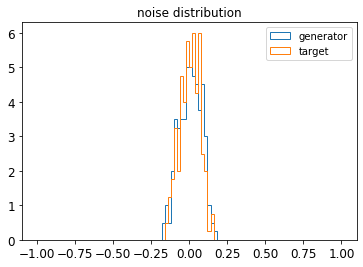

[0.840123713 -0.377653301]
Epoch: 2000 | disc_loss: 0.02762533351778984 | gen_loss: 0.48421013355255127
Epoch: 2100 | disc_loss: 0.023143259808421135 | gen_loss: 0.5019282698631287
Epoch: 2200 | disc_loss: 0.02530091069638729 | gen_loss: 0.4665081799030304
Epoch: 2300 | disc_loss: 0.025937629863619804 | gen_loss: 0.48864325881004333
Epoch: 2400 | disc_loss: 0.02563784457743168 | gen_loss: 0.489368200302124


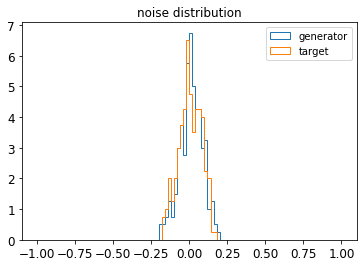

[-0.0859060064 -0.513744]
Epoch: 2500 | disc_loss: 0.0188196562230587 | gen_loss: 0.49694985151290894
Epoch: 2600 | disc_loss: 0.018056048080325127 | gen_loss: 0.48281317949295044
Epoch: 2700 | disc_loss: 0.0209225844591856 | gen_loss: 0.4879011809825897
Epoch: 2800 | disc_loss: 0.018486429005861282 | gen_loss: 0.5038190484046936
Epoch: 2900 | disc_loss: 0.016739096492528915 | gen_loss: 0.48283180594444275


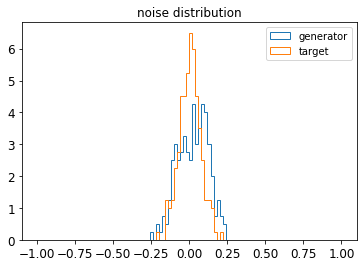

[0.073306784 -1.0118345]
Epoch: 3000 | disc_loss: 0.015421790070831776 | gen_loss: 0.49221983551979065
Epoch: 3100 | disc_loss: 0.01014481857419014 | gen_loss: 0.4885985553264618
Epoch: 3200 | disc_loss: 0.015381740406155586 | gen_loss: 0.4953120946884155
Epoch: 3300 | disc_loss: 0.014583257026970387 | gen_loss: 0.495677649974823
Epoch: 3400 | disc_loss: 0.01490415446460247 | gen_loss: 0.5027728080749512


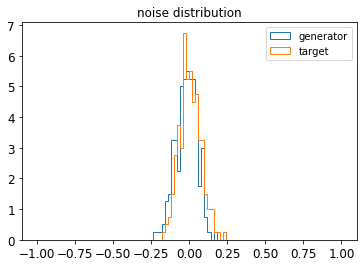

[0.0158290416 0.734882236]
Epoch: 3500 | disc_loss: 0.014002682641148567 | gen_loss: 0.4941369593143463
Epoch: 3600 | disc_loss: 0.009623805992305279 | gen_loss: 0.5170171856880188
Epoch: 3700 | disc_loss: 0.012422725558280945 | gen_loss: 0.503652811050415
Epoch: 3800 | disc_loss: 0.015034245327115059 | gen_loss: 0.49005430936813354
Epoch: 3900 | disc_loss: 0.010010069236159325 | gen_loss: 0.5288927555084229


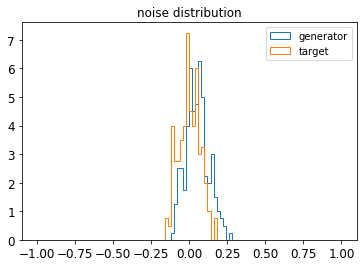

[-0.506458342 -0.271491438]
Epoch: 4000 | disc_loss: 0.016219060868024826 | gen_loss: 0.5046373009681702
Epoch: 4100 | disc_loss: 0.012106380425393581 | gen_loss: 0.4877531826496124
Epoch: 4200 | disc_loss: 0.014368233270943165 | gen_loss: 0.5066102743148804
Epoch: 4300 | disc_loss: 0.012130090966820717 | gen_loss: 0.5250713229179382
Epoch: 4400 | disc_loss: 0.018445249646902084 | gen_loss: 0.5100896954536438


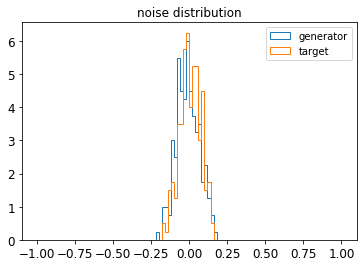

[0.302578747 1.31974292]
Epoch: 4500 | disc_loss: 0.009965134784579277 | gen_loss: 0.5150012373924255
Epoch: 4600 | disc_loss: 0.009144969284534454 | gen_loss: 0.5386748909950256
Epoch: 4700 | disc_loss: 0.0074642193503677845 | gen_loss: 0.5164375305175781
Epoch: 4800 | disc_loss: 0.009191161021590233 | gen_loss: 0.5174399018287659
Epoch: 4900 | disc_loss: 0.009348428808152676 | gen_loss: 0.5328867435455322


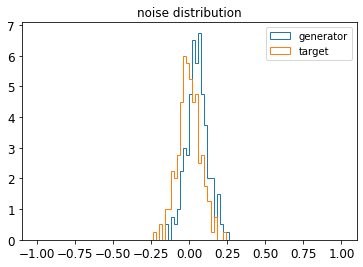

[0.185944796 1.20632386]
Epoch: 5000 | disc_loss: -0.00043480400927364826 | gen_loss: 0.5089583396911621
Epoch: 5100 | disc_loss: 0.007852202281355858 | gen_loss: 0.5113409757614136
Epoch: 5200 | disc_loss: 0.0012069582007825375 | gen_loss: 0.5266115665435791
Epoch: 5300 | disc_loss: 0.005219246260821819 | gen_loss: 0.507780134677887
Epoch: 5400 | disc_loss: 0.004646698012948036 | gen_loss: 0.5038018226623535


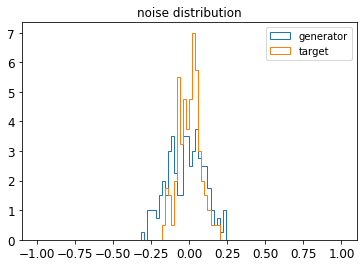

[0.518383741 0.19660157]
Epoch: 5500 | disc_loss: 0.0023217429406940937 | gen_loss: 0.509387731552124
Epoch: 5600 | disc_loss: 0.007570034824311733 | gen_loss: 0.5244619250297546
Epoch: 5700 | disc_loss: 0.006232769228518009 | gen_loss: 0.5017479658126831
Epoch: 5800 | disc_loss: 0.0027524023316800594 | gen_loss: 0.5090664029121399
Epoch: 5900 | disc_loss: 0.0005806697299703956 | gen_loss: 0.48943468928337097


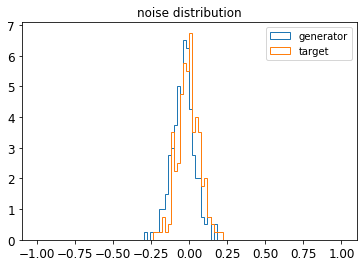

[-0.371745557 1.12207556]
Epoch: 6000 | disc_loss: 0.006387685425579548 | gen_loss: 0.5051712989807129
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/saved_model/assets
Time for the training is 448.9891002178192 sec,
CPU times: user 8min 51s, sys: 25.6 s, total: 9min 17s
Wall time: 7min 28s


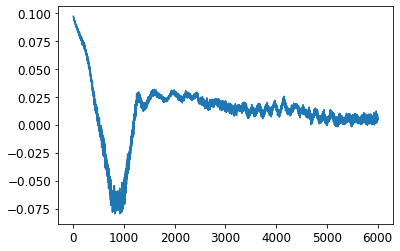

In [20]:
%%time

#generator_optimizer, discriminator_optimizer = gan_optimizers(gen_learning_rate=gen_learning_rate, disc_learning_rate = disc_learning_rate)
start = time.time()
gen_train(6001, 100)
time_to_train_gan = time.time()-start
tf.print ('Time for the training is {} sec,'.format( time.time()-start))


# AE training

In [21]:
%%time

gan_decoder = get_gan_decoder(M)
gan_encoder = get_gan_encoder(M)



gan_AE = tf.keras.models.Sequential([gan_encoder,generator,gan_decoder])
data, test_data = random_sample(10000000), random_sample(10000)
start = time.time()
gan_AE.compile(optimizer=keras.optimizers.Adam(),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = gan_AE.fit(data, data, batch_size=500,steps_per_epoch=100, epochs=10)
time_to_train_gan += time.time()-start
tf.print ('Time for the training is {} sec,'.format( time.time()-start))
gan_AE.summary()  

Train on 10000000 samples
Epoch 1/10
   50000/10000000 [..............................] - ETA: 2:06 - loss: 0.0295 - accuracy: 0.9956Time for the training is 8.70598030090332 sec,
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, None)              1922      
_________________________________________________________________
model (Model)                (None, 2)                 4622      
_________________________________________________________________
sequential_4 (Sequential)    (None, 16)                1680      
Total params: 8,224
Trainable params: 3,602
Non-trainable params: 4,622
_________________________________________________________________
CPU times: user 11.4 s, sys: 473 ms, total: 11.9 s
Wall time: 9.35 s


### Training MI

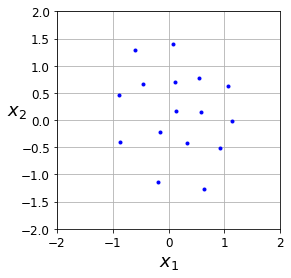

In [22]:
gan_encoder.trainable = False
gan_decoder.trainable = False

test_encoding(M,n)   


In [0]:
# test msg sequence for normal encoding
N_test = 500000
test_msg = np.random.randint(M, size=N_test)

### Comparison

In [24]:
gan_bber_data = gan_Test_AE(test_msg)


Progress: 6 of 30 parts
Progress: 12 of 30 parts
Progress: 18 of 30 parts
Progress: 24 of 30 parts
Progress: 30 of 30 parts


time to train the AE Model with GAN 457.69506788253784


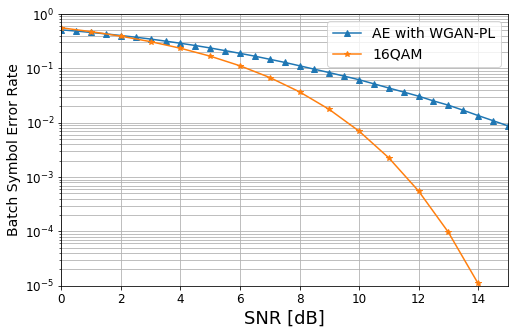

In [25]:
# Approximate 16 QAM Error
def SIXT_QAM_sim(ebno):
    return (3.0/2)*special.erfc(np.sqrt((4.0/10)*10.**(ebno/10)))

ebnodbs = np.linspace(0,15,16)
fig = plt.figure(figsize=(8, 5))
plt.semilogy(gan_bber_data[0], gan_bber_data[1], '^-')
plt.semilogy(ebnodbs, SIXT_QAM_sim(ebnodbs), '*-');
plt.gca().set_ylim(1e-5, 1)
plt.gca().set_xlim(0, 15)
plt.ylabel("Batch Symbol Error Rate", fontsize=14, rotation=90)
plt.xlabel("SNR [dB]", fontsize=18)
plt.legend(['AE with WGAN-PL', '16QAM'],
           prop={'size': 14}, loc='upper right');
plt.grid(True, which="both")
print('time to train the AE Model with GAN',time_to_train_gan)


In [26]:
bber_data_rayleigh = Test_AE_rayleigh(test_msg)

Progress: 6 of 30 parts
Progress: 12 of 30 parts
Progress: 18 of 30 parts
Progress: 24 of 30 parts
Progress: 30 of 30 parts


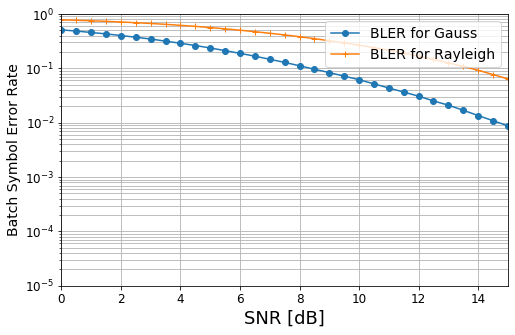

In [27]:
def SIXT_QAM_sim(ebno):
    return (3.0/2)*special.erfc(np.sqrt((4.0/10)*10.**(ebno/10)))

ebnodbs = np.linspace(0,15,16)
fig = plt.figure(figsize=(8, 5))
plt.semilogy(gan_bber_data[0], gan_bber_data[1], 'o-')
plt.semilogy(bber_data_rayleigh[0], bber_data_rayleigh[1], '+-')
#plt.semilogy(ebnodbs, SIXT_QAM_sim(ebnodbs), '^-');
plt.gca().set_ylim(1e-5, 1)
plt.gca().set_xlim(0, 15)
plt.ylabel("Batch Symbol Error Rate", fontsize=14, rotation=90)
plt.xlabel("SNR [dB]", fontsize=18)
plt.legend(['BLER for Gauss','BLER for Rayleigh'],
           prop={'size': 14}, loc='upper right');
plt.grid(True, which="both")